# Experiment 1 results and visualizations

In [164]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

from models.usad import get_usad
from training_set_update.slidingWindow import sliding_window as sw_helper
from nonconformity_scores.nonconformity_wrapper import calc_nonconformity_scores

## Paths

In [165]:
data_representation_length = 100
dataset_category, collection_id, dataset_id = 'multivariate', 'Daphnet', 'S03R01E0'
model_id, ls_id, anomaly_score_id = 'usad', 'sw_mu_sig', 'anomaly_likelihood'
date_id = '20240215_164136'

In [166]:
data_path = f'../data/{dataset_category}/{collection_id}/{dataset_id}.test.csv'
experiment_path = f'../out/{dataset_category}/{collection_id}/experiment1/{collection_id}/{dataset_id}/{model_id}-{ls_id}-{anomaly_score_id}/{date_id}'
initial_weights_path = f'../out/{dataset_category}/{collection_id}/experiment1/{collection_id}/{dataset_id}/initial_weights/{date_id}/{model_id}.h5'
anomalies_path = f'../out/{dataset_category}/{collection_id}/experiment1/{collection_id}/{dataset_id}/artificial_anomalies/{date_id}'

## Load dataset, models and anomalies

In [167]:
dataset = pd.read_csv(data_path).values[:, 1:-1].astype(float)
input_shape = (data_representation_length, dataset.shape[1])
finetuned_models_paths = [(f'{experiment_path}/{x}', int(re.findall(r'\d+', x)[0])) for x in os.listdir(experiment_path) if x.endswith('.h5')]
finetuned_models_paths = sorted(finetuned_models_paths, key=lambda x: x[1])
anomalies = []
for anomaly_path in [x for x in os.listdir(anomalies_path) if not x.startswith('.')]:
    start, end = int(re.findall(r'\d+', anomaly_path)[0]), int(re.findall(r'\d+', anomaly_path)[1])
    anomalies.append((pd.read_csv(f'{anomalies_path}/{anomaly_path}', index_col='update_index').to_numpy(), (start, end)))
anomalies = sorted(anomalies, key=lambda x: x[1][0])

## Analyze nonconformity scores after finetuning

In [179]:
nc_score_id, buffer = 'cosine_sim', 50
# for idx in range(len(finetuned_models_paths)):
idx = 2
model1_path = initial_weights_path if idx == 0 else finetuned_models_paths[idx-1][0]
model2_path = finetuned_models_paths[idx][0]
start_window, end_window = finetuned_models_paths[idx][1] - data_representation_length, finetuned_models_paths[idx][1] + 2000
anomaly, start_anomaly, end_anomaly = anomalies[idx][0], anomalies[idx][1][0], anomalies[idx][1][1]
dataset_copy = dataset.copy()

model1 = get_usad(input_shape=input_shape, latent_size=input_shape[0]//10)
model1.load_weights(model1_path)
model2 = get_usad(input_shape=input_shape, latent_size=input_shape[0]//10)
model2.load_weights(model2_path)

dataset_copy[start_anomaly:end_anomaly] = anomaly
samples = sw_helper(
    outer_window=dataset_copy[start_window:end_window],
    feature_vector_length=data_representation_length,
    training_set_length=end_window-start_window-data_representation_length)

predictions1 = model1.predict(samples)[-1]
predictions2 = model2.predict(samples)[-1]
nc_scores1 = calc_nonconformity_scores(samples, predictions1, measure=nc_score_id)
nc_scores2 = calc_nonconformity_scores(samples, predictions2, measure=nc_score_id)

nc_mean1 = np.mean(nc_scores1[:start_anomaly-start_window])
nc_mean2 = np.mean(nc_scores2[:start_anomaly-start_window])
nc_std1 = np.std(nc_scores1[:start_anomaly-start_window])
nc_std2 = np.std(nc_scores2[:start_anomaly-start_window])

nc_anomaly1 = np.max(nc_scores1[start_anomaly-start_window: end_anomaly-start_window + buffer])
nc_anomaly_pos1 = np.argmax(nc_scores1[start_anomaly-start_window: end_anomaly-start_window + buffer])
nc_anomaly2 = np.max(nc_scores2[start_anomaly-start_window: end_anomaly-start_window + buffer])
nc_anomaly_pos2 = np.argmax(nc_scores2[start_anomaly-start_window: end_anomaly-start_window + buffer])

nc_diff1 = nc_anomaly1 - nc_mean1
nc_diff2 = nc_anomaly2 - nc_mean2

# print(f'Idx {idx} - Mean 1: {nc_mean1:.6f} - Mean 2: {nc_mean2:.6f}')
# print(f'Idx {idx} - Std 1: {nc_std1:.6f} - Std 2: {nc_std2:.6f}')
print(f'Idx {idx} - Diff 1: {nc_diff1:.6f} - Diff 2: {nc_diff2:.6f} - Diff 2 bigger? {nc_diff2 > nc_diff1} -> by {nc_diff2 - nc_diff1:.6f}')

Idx 2 - Diff 1: 0.139416 - Diff 2: 0.195070 - Diff 2 bigger? True -> by 0.055654


In [210]:
start_anomaly-start

90

In [188]:
end_anomaly-start_window + buffer

260

In [195]:
nc_scores2[180:260]

array([0.29008514, 0.26258812, 0.2297461 , 0.19593101, 0.167275  ,
       0.13991673, 0.1176337 , 0.1108016 , 0.1208865 , 0.14020852,
       0.17005352, 0.20549541, 0.26809079, 0.31706557, 0.36088015,
       0.39723474, 0.39778868, 0.38205979, 0.36109046, 0.34129818,
       0.32936045, 0.32017951, 0.32087044, 0.32511878, 0.32936096,
       0.3318863 , 0.32689635, 0.31650945, 0.28168198, 0.2075765 ,
       0.20831608, 0.20242322, 0.19956425, 0.19635549, 0.20066623,
       0.2047738 , 0.20980511, 0.20335759, 0.20782762, 0.20860655,
       0.22893789, 0.23208831, 0.2370239 , 0.24034226, 0.24295407,
       0.23765088, 0.24092109, 0.23812388, 0.22204135, 0.22456421,
       0.22412721, 0.21803102, 0.22004609, 0.21532748, 0.2184177 ,
       0.21935993, 0.22355719, 0.22700452, 0.23027343, 0.2292183 ,
       0.23184562, 0.23617578, 0.23178034, 0.22431685, 0.21885249,
       0.20830779, 0.20917866, 0.19898064, 0.20129387, 0.20318675,
       0.21253999, 0.21543828, 0.22241981, 0.2279643 , 0.22136

In [196]:
end-start

160

## Visualization
This should be a plot of following figures stacked on top of each other:
- Dataset with anomaly
- Predictions of model 1 (color 1)
- Predictions of model 2 (color 2)
- Nonconformity scores of both models with vertical bar measuring the maximum difference to before level

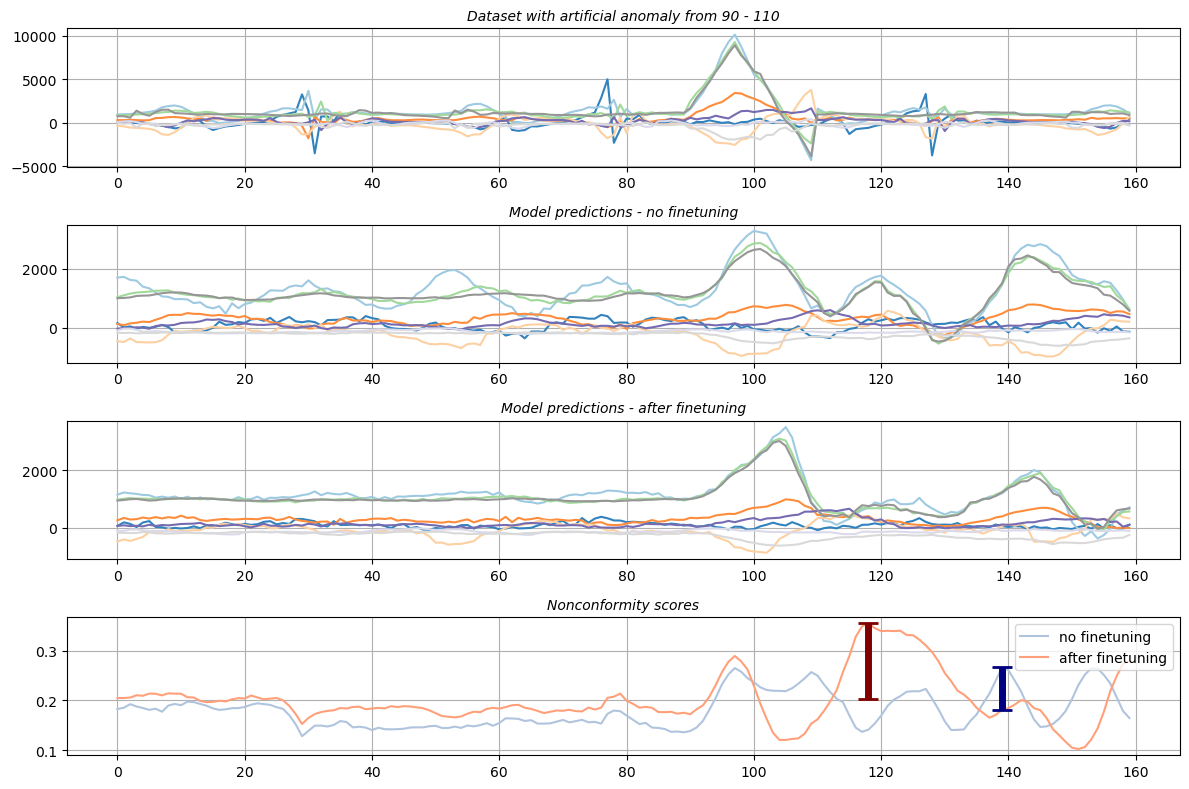

In [214]:
fig = plt.figure(figsize=(12,8), tight_layout=True)
colors = [c for c in iter(cm.tab20c(np.linspace(0, 1, x_len)))]
y_len, x_len = end_anomaly+buffer - (start_window+data_representation_length), input_shape[1]
x = np.stack([np.arange(0, x_len) for i in range(y_len)], axis=1)
y = np.stack([np.arange(0, y_len) for i in range(x_len)])
start, end = start_window+data_representation_length, end_anomaly+buffer

# Dataset with anomaly
ax1 = fig.add_subplot(4, 1, 1)
z1 = dataset_copy[start : end].T
# z1 = (z1 - np.mean(z1, axis=1, keepdims=True)) / np.std(z1, axis=1, keepdims=True)
# dy = (z1.min() - z1.max()) * 0.7
# ax1.set_yticks([i*dy for i in range(x_len)], labels=[f'ch{i}' for i in range(x_len)])
for i in range(x_len):
    ax1.plot(y[i], z1[i], color=colors[i])
ax1.grid()
ax1.set_title(f'Dataset with artificial anomaly from {start_anomaly-start} - {end_anomaly-start}', fontstyle="italic", size=10)

# Model 1 predictions
ax2 = fig.add_subplot(4, 1, 2)
# z2 = np.mean(predictions1[:end-start], axis=1).T
z2 = predictions1[:end-start, -1].T
# dy = (z2.min() - z2.max()) * 0.7
# ax2.set_yticks([i*dy for i in range(x_len)]) #, labels=[f'ch{i}' for i in range(x_len)])
for i in range(x_len):
    ax2.plot(y[i], z2[i], color=colors[i])
ax2.grid()
ax2.set_title('Model predictions - no finetuning', fontstyle="italic", size=10)

# Model 2 predictions
ax3 = fig.add_subplot(4, 1, 3)
# z3 = np.mean(predictions2[:end-start], axis=1).T
z3 = predictions2[:end-start, -1].T
# dy = (z2.min() - z2.max()) * 0.7
# ax3.set_yticks([i*dy for i in range(x_len)]) #, labels=[f'ch{i}' for i in range(x_len)])
for i in range(x_len):
    ax3.plot(y[i], z3[i], color=colors[i])
ax3.grid()
ax3.set_title('Model predictions - after finetuning', fontstyle="italic", size=10)

# Nonconformity scores
ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(nc_scores1[:end-start], color='lightsteelblue', label='no finetuning')
ax4.plot(nc_scores2[:end-start], color='lightsalmon', label='after finetuning')
ax4.grid()
x_pos1 = np.argmax(nc_scores1[:end-start])
y_pos1 = nc_mean1 + 0.5 * (np.max(nc_scores1[:end-start]) - nc_mean1)
x_err1, y_err1 = 0, 0.5 * (np.max(nc_scores1[:end-start]) - nc_mean1)
x_pos2 = np.argmax(nc_scores2[:end-start])
y_pos2 = nc_mean2 + 0.5 * (np.max(nc_scores2[:end-start]) - nc_mean2)
x_err2, y_err2 = 0, 0.5 * (np.max(nc_scores2[:end-start]) - nc_mean2)
ax4.errorbar(x_pos1, y_pos1, xerr=x_err1, yerr=y_err1, color='navy', linewidth=5, capsize=7, capthick=2)
ax4.errorbar(x_pos2, y_pos2, xerr=x_err2, yerr=y_err2, color='maroon', linewidth=5, capsize=7, capthick=2)
ax4.set_title('Nonconformity scores', fontstyle="italic", size=10)
ax4.legend(loc="upper right")

plt.savefig(f'{experiment_path}/artifical_anomaly_finetuning_experiment1.png')

In [183]:
start_anomaly - start

90